In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sns
import random

In [2]:
# load the clean data
updates = pd.read_csv('../Clean/updates.csv')

In [3]:
# assign a number code to each of the topics to create an id column that has the participant code and the topic they were updating on.
updates.loc[updates['topic']=='Math', 'topic_num'] = '1'
updates.loc[updates['topic']=='Science and Technology', 'topic_num'] = '2'
updates.loc[updates['topic']=='Verbal', 'topic_num'] = '3'
updates.loc[updates['topic']=='Pop-Culture and Art', 'topic_num'] = '4'
updates.loc[updates['topic']=='Sports and Video Games', 'topic_num'] = '5'
updates.loc[updates['topic']=='US Geography', 'topic_num'] = '6'

# make a column that combines the participant code and the topic number into a singe id for a participant in a task.
updates['player_code'] = updates['code']+updates['topic_num']

updates.reset_index(inplace=True)

# need to rename the columns type and rate from updates to theta and omega
updates = updates.rename(columns={'type':'theta', 'rate':'omega'})

In [4]:
### Add columns to determine how the Subject's beliefs about their type changed across rounds
# for each task, determine whether their belief changed from the initial belief or not.
# check at every row if the belief is different from the last_button. 
updates['current_belief_start'] = updates['last_button'] - updates['belief']

# for rows in which rond_number is 2 or more, check if last_button is the same as last_button in the previous round_number for that player_code
# and register the size of the belief change in the column belief_change
updates['belief_change'] = np.where(updates['round_number']>1, 
                                     updates['last_button'] - updates['last_button'].shift(1), 
                                     updates['current_belief_start'])

# create a column that indicates if the belief changed or not in that round relative to the previous round
updates['change_indicator'] = 0
updates.loc[updates['belief_change']!=0, 'change_indicator'] = 1
# split the sample into two. Those who never changed their belief and those who did
# to do so, first group by player_code and then check if the sum of the change_indicator is 0 or not
updates['change_indicator_sum'] = updates.groupby('player_code')['change_indicator'].transform('sum')

In [5]:
# compute Likelihoods for each player-task
#for each subject, calulate the likelihood of each of the types given the signals they saw.
# the probability matrices are needed for th calculatin of the likelihood
ml = np.array([[.20, .25, .40], [.07, .30, .45], [.02, .20, .50]])
mm = np.array([[.40, .45, .65], [.30, .65, .69], [.05, .50, .80]])
mh = np.array([[.45, .55, .75], [.35, .69, .80], [.25, .65, .98]])

msc = [ml, mm, mh]

for i in range(len(updates['player_code'].unique())):
    # get a single path for a single player
    c = updates['player_code'].unique()[i]
    player = updates.loc[updates['player_code']==c, :]
    # for each round get the history of (effort, signal) pairs up to that round
    p_t=[]
    lr_t=[]
    prior = [1/3, 1/3, 1/3]

    for t in [a+2 for a in range(10)]:
        
        e_t = int(player.loc[player['round_number']==t, 'effort'])
        theta = int(player.loc[player['round_number']==t, 'theta'])
        belief_prev = int(player.loc[player['round_number']==t-1, 'last_button'])
        belief_new = int(player.loc[player['round_number']==t, 'last_button'])
        omega = int(player.loc[player['round_number']==t, 'omega'])
        s_t = int(player.loc[player['round_number']==t, 'signal'])
        f_t = 10-s_t

        # update the belief about omega for each of the types separately
        posterior_new = np.diag(np.diagflat(prior)@np.diagflat(sp.stats.binom.pmf(s_t, 10, msc[belief_new][e_t, :], loc=0)))/sum(np.diag(np.diagflat(prior)@np.diagflat(sp.stats.binom.pmf(s_t, 10, msc[belief_new][e_t, :], loc=0))))
        posterior_prev = np.diag(np.diagflat(prior)@np.diagflat(sp.stats.binom.pmf(s_t, 10, msc[belief_prev][e_t, :], loc=0)))/sum(np.diag(np.diagflat(prior)@np.diagflat(sp.stats.binom.pmf(s_t, 10, msc[belief_prev][e_t, :], loc=0))))

        p_new = sp.stats.binom.pmf(s_t, 10, msc[belief_new][e_t, :], loc=0)@posterior_new
        p_prev = sp.stats.binom.pmf(s_t, 10, msc[belief_prev][e_t, :], loc=0)@posterior_prev
        # multiply all the elements in p_true and p_belief
        l_new = np.prod(p_new)
        l_prev = np.prod(p_prev)
        # calculate the likelihood ratio
        lr_t.append(l_new/l_prev)
    # add a column to the updates data frame with the likelihood ratio for each round
    updates.loc[(updates['player_code']==c) & (updates['round_number']>=2), 'lr'] = lr_t

In [6]:
# calculate the average of lr for the rows in which change_indicator is 1 and lr is less than 5
# this excludes observations in which the likelihood ratio is too high and the update is not informative
alpha = updates.loc[(updates['change_indicator']==1)& (updates['lr']<5), 'lr'].mean()
alpha

1.0928800828808174

In [7]:
# calculate alpha for each treatment separately, still dropping paths in which subjects changed their belief more than 9 times
alpha_ego = updates.loc[(updates['change_indicator']==1) & (updates['change_indicator_sum']<=9) & (updates['treatment']=='ego')& (updates['lr']<5), 'lr'].mean()
alpha_stereo = updates.loc[(updates['change_indicator']==1) & (updates['change_indicator_sum']<=9) & (updates['treatment']=='stereotype')& (updates['lr']<5), 'lr'].mean()

print('alpha is ' + str(alpha_ego) + 'in the ego condition')
print('alpha is ' + str(alpha_stereo) + 'in the stereotype condition')

alpha is 1.0836707828833205in the ego condition
alpha is 1.098783698398442in the stereotype condition


In [8]:
# test if the difference in alpha is significant
sp.stats.ttest_ind(updates.loc[(updates['treatment']=='ego') & (updates['round_number']>2) & (updates['change_indicator_sum']<=9) & 
                            (updates['change_indicator']==1) & (updates['lr']<5) , 'lr'], 
                updates.loc[(updates['treatment']=='stereotype') & (updates['round_number']>2) & (updates['change_indicator_sum']<=9) & 
                            (updates['change_indicator']==1) & (updates['lr']<5) , 'lr'])

Ttest_indResult(statistic=-0.14809609585207406, pvalue=0.8822862680279493)

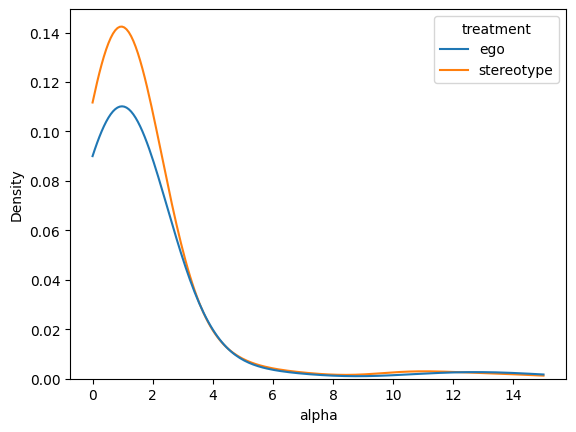

In [9]:
# estimate the distribution of alpha
# take the log of the lr
updates['log_lr'] = np.log(updates['lr'])
# plot the distribution of log_lr
sns.kdeplot(data = updates.loc[(updates['change_indicator']==1) ], x = 'lr', 
            hue='treatment', bw_adjust=.2, clip=(0, 15))
plt.xlabel('alpha')

# save the figure
plt.savefig('../figures/lr_hist.png', dpi=300, bbox_inches='tight')